<a href="https://colab.research.google.com/github/mokoshin0720/ml-tutorials/blob/main/Enc_Dec%5BTransformer%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インストール -> 再起動

In [1]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

!pip install torchtext==0.8.0
!pip install torch==1.7.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

# 必要なモジュールのimport

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.metrics import bleu_score
from torchtext import data
from torchtext.data import Field
import MeCab

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# データの前処理

分かち書き

In [87]:
def tokenizer(text):
    return m.parse(text).split()

In [88]:
m = MeCab.Tagger("-Owakati")

# Fieldオブジェクトの作成
title = data.Field(tokenize=tokenizer, init_token="<sos>", eos_token="<eos>")
right = data.Field(tokenize=tokenizer, init_token="<sos>", eos_token="<eos>")
left = data.Field(tokenize=tokenizer, init_token="<sos>", eos_token="<eos>")

# CSVファイルを読み込み、TabularDatasetオブジェクトを作成
train_data, test_data = data.TabularDataset.splits(
    path = "/content/drive/MyDrive/data/nakazawa_lab/youtuber_title/",
    train = "youtube_test.csv",
    test = "youtube_test.csv",
    format="csv",
    fields=[('title', title), ('right', right), ('left', left)]
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [89]:
for example in train_data[:3]:
    print(example.title)
    print(example.right)
    print(example.left)
    print("="*30)

['\ufeff', '結果', 'を', '出す', '前', 'に', '豪語', 'する', '人', 'は', '、', 'たいてい', '小物', '【', '質疑', '応答', '#', '36', '】']
['、', 'たいてい', '小物', '【', '質疑', '応答', '#', '36', '】']
['、', 'は', '人', 'する', '豪語', 'に', '前', '出す', 'を', '結果']
['人生', '変わる', '7', 'つ', 'の', '時間', '感覚', '改善', 'ツール']
['時間', '感覚', '改善', 'ツール']
['時間', 'の', 'つ', '7', '変わる', '人生']
['大衆', 'は', '常に', '間違っ', 'て', 'いる', '。', '特に', 'あなた', 'が', '成功', 'し', 'たい', 'と', '思っ', 'て', 'いる', '場合', 'は', '【', '質疑', '応答', '#', '35', '】']
['て', 'いる', '。', '特に', 'あなた', 'が', '成功', 'し', 'たい', 'と', '思っ', 'て', 'いる', '場合', 'は', '【', '質疑', '応答', '#', '35', '】']
['て', '間違っ', '常に', 'は', '大衆']


単語辞書の作成

In [90]:
title.build_vocab(train_data)
right.build_vocab(train_data)
left.build_vocab(train_data)

# Transformerモデル

Encoder -> memoryを返す

In [7]:
class Encoder(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Encoder, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_size,
            nhead=num_heads,
            dim_feedforward=forward_expansion,
            dropout=dropout,
        )
        encoder_norm = nn.LayerNorm(normalized_shape=embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_encoder_layers,
            norm=encoder_norm
        )

        self.device = device
        self.src_pad_idx = src_pad_idx
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src_seq_length, N = src.shape
        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        memory = self.encoder(
            src=embed_src,
            src_key_padding_mask=src_padding_mask
        )
        return memory

        def make_src_mask(self, src):
            src_mask = src.transpose(0, 1) == self.src_pad_idx
            return src_mask.to(self.device)

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx
        return src_mask.to(self.device)

Decoder -> memoryを受け取って、生成結果を返す

In [8]:
class Decoder(nn.Module):
    def __init__(
        self,
        embedding_size,
        trg_vocab_size,
        num_heads,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Decoder, self).__init__()

        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embedding_size,
            nhead=num_heads,
            dim_feedforward=forward_expansion,
            dropout=dropout,
        )
        decoder_norm = nn.LayerNorm(normalized_shape=embedding_size)

        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=num_decoder_layers,
            norm=decoder_norm
        )

        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)

        self.device = device
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, memory):
        trg_seq_length, N = trg.shape
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )
        trg_mask = self.generate_square_subsequent_mask(trg_seq_length).to(self.device)

        out = self.decoder(
            tgt=embed_trg,
            memory=memory,
            tgt_mask=trg_mask,
        )

        out = self.fc_out(out)
        return out

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# ハイパーパラメータ

In [23]:
num_epochs = 100
learning_rate = 3e-4
batch_size = 32

In [24]:
src_vocab_size = len(title.vocab)
trg_vocab_size = len(title.vocab)
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len = 50
forward_expansion = 4
src_pad_idx = 0

# 学習

In [25]:
train_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, test_data),
        batch_size=batch_size,
        sort_within_batch=True,
        sort_key=lambda x: len(x.title),
        device=device,
        )

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


モデルの宣言

In [12]:
encoder = Encoder(
    embedding_size,
    src_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

decoder_left = Decoder(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

decoder_right = Decoder(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

optimizerとloss関数の宣言

In [13]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_left_optimizer = optim.Adam(decoder_left.parameters(), lr=learning_rate)
decoder_right_optimizer = optim.Adam(decoder_right.parameters(), lr=learning_rate)

encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    encoder_optimizer, factor=0.1, patience=10, verbose=True
)
decoder_left_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    decoder_left_optimizer, factor=0.1, patience=10, verbose=True
)
decoder_right_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    decoder_right_optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [68]:
'''
Decoderのみ
'''
encoder = Encoder(
    embedding_size,
    src_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

decoder = Decoder(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    encoder_optimizer, factor=0.1, patience=10, verbose=True
)
decoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    decoder_optimizer, factor=0.1, patience=10, verbose=True
)
pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

'''
学習
'''
mean_losses = []
for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")
    losses = []
    output2bests = []

    for batch_idx, batch in enumerate(train_iterator):
        print("="*30)
        '''
        入力データ
        '''
        inp_data = batch.title.to(device)
        target = batch.title.to(device)

        '''
        encoderとdecoderに渡す
        '''
        memory = encoder(inp_data)
        output = decoder(target[:-1, :], memory)

        '''
        勾配の初期化
        '''
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        '''
        loss計算
        '''
        output = output.reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        loss = criterion(output, target)
        losses.append(loss.item())

        '''
        誤差逆伝搬
        '''
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

        '''
        重みの更新
        '''
        encoder_optimizer.step()
        decoder_optimizer.step()

        '''
        正解率検証
        '''
        # for b in batch:
        #     if b == None: continue
        #     for title in b:
        #         for i in range(12):
        #             print(title[:, i]) # これで文章の列になっている
        #             sentence = title[:, i]
        # print(output2bests)
        # print(batch.title)

    '''
    バッチの平均ロスを計算
    '''
    mean_loss = sum(losses) / len(losses)

    '''
    スケジューラー（学習率の調整）
    '''
    decoder_scheduler.step(mean_loss)
    '''
    loss append
    '''
    mean_losses.append(mean_loss)
    print("loss: ", mean_loss)

[Epoch 0 / 100]
loss:  4.925047397613525
[Epoch 1 / 100]
loss:  3.2984509468078613
[Epoch 2 / 100]
loss:  3.4900310039520264
[Epoch 3 / 100]
loss:  3.0082504749298096
[Epoch 4 / 100]


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


loss:  2.915499210357666
[Epoch 5 / 100]
loss:  2.736375331878662
[Epoch 6 / 100]
loss:  2.660460948944092
[Epoch 7 / 100]
loss:  2.537870168685913
[Epoch 8 / 100]
loss:  2.4466733932495117
[Epoch 9 / 100]
loss:  2.362398147583008
[Epoch 10 / 100]
loss:  2.263850688934326
[Epoch 11 / 100]
loss:  2.1747195720672607
[Epoch 12 / 100]
loss:  2.0564146041870117
[Epoch 13 / 100]
loss:  1.9726804494857788
[Epoch 14 / 100]
loss:  1.8753373622894287
[Epoch 15 / 100]
loss:  1.7538468837738037
[Epoch 16 / 100]
loss:  1.6453932523727417
[Epoch 17 / 100]
loss:  1.5397677421569824
[Epoch 18 / 100]
loss:  1.4562197923660278
[Epoch 19 / 100]
loss:  1.3567721843719482
[Epoch 20 / 100]
loss:  1.2523783445358276
[Epoch 21 / 100]
loss:  1.1573165655136108
[Epoch 22 / 100]
loss:  1.0554534196853638
[Epoch 23 / 100]
loss:  0.9554420113563538
[Epoch 24 / 100]
loss:  0.8706664443016052
[Epoch 25 / 100]
loss:  0.791046679019928
[Epoch 26 / 100]
loss:  0.7096683382987976
[Epoch 27 / 100]
loss:  0.62711685895919

学習開始(Encoder-Decoderモデル)

In [ ]:
# mean_losses_left = []
# mean_losses_right = []
# losses = []

# for epoch in range(num_epochs):
#     print(f"[Epoch {epoch} / {num_epochs}]")
#     losses_left = []
#     losses_right = []

#     for batch_idx, batch in enumerate(train_iterator):
#         '''
#         入力データ
#         '''
#         inp_data = batch.title.to(device)
#         target_left = batch.left.to(device)
#         target_right = batch.right.to(device)

#         '''
#         encoderとdecoderに渡す
#         '''
#         memory = encoder(inp_data)
#         output_left = decoder_left(target_left[:-1, :], memory)
#         output_right = decoder_right(target_right[:-1, :], memory)

#         '''
#         outputの形式を変更
#         '''
#         output_left = output_left.reshape(-1, output_left.shape[2])
#         target_left = target_left[1:].reshape(-1)
#         output_right = output_right.reshape(-1, output_right.shape[2])
#         target_right = target_right[1:].reshape(-1)

#         '''
#         勾配の初期化
#         '''
#         encoder_optimizer.zero_grad()
#         decoder_left_optimizer.zero_grad()
#         decoder_right_optimizer.zero_grad()

#         '''
#         loss計算
#         '''
#         loss_left = criterion(output_left, target_left)
#         loss_right = criterion(output_right, target_right)
#         losses_left.append(loss_left.item())
#         losses_right.append(loss_right.item())

#         '''
#         誤差逆伝搬
#         '''
#         loss_left.backward(retain_graph=True)
#         loss_right.backward()
#         torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
#         torch.nn.utils.clip_grad_norm_(decoder_left.parameters(), max_norm=1)
#         torch.nn.utils.clip_grad_norm_(decoder_right.parameters(), max_norm=1)

#         '''
#         重みの更新
#         '''
#         encoder_optimizer.step()
#         decoder_left_optimizer.step()
#         decoder_right_optimizer.step()

#     '''
#     バッチの平均ロスを計算
#     '''
#     mean_loss_left = sum(losses_left) / len(losses_left)
#     mean_loss_right = sum(losses_right) / len(losses_right)

#     '''
#     スケジューラー（学習率の調整）
#     '''
#     decoder_left_scheduler.step(mean_loss_left)
#     decoder_right_scheduler.step(mean_loss_right)
#     '''
#     loss append
#     '''
#     mean_losses_left.append(mean_loss_left)
#     mean_losses_right.append(mean_loss_right)
#     print("left: ", mean_loss_left)
#     print("right: ", mean_loss_right)

損失関数の可視化

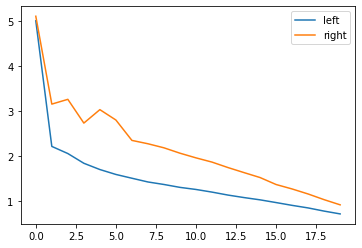

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(mean_losses_left, label='left')
plt.plot(mean_losses_right, label='right')
plt.legend()

# 予測

In [65]:
def translate_sentence(encoder, decoder_left, decoder_right, sentence, title, device, max_length=50):
    if type(sentence) == str:
        tokens = [token for token in tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, title.init_token)
    tokens.append(title.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [title.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs_left = [title.vocab.stoi["<sos>"]]
    outputs_right = [title.vocab.stoi["<sos>"]]

    for i in range(max_length):
        trg_tensor_left = torch.LongTensor(outputs_left).unsqueeze(1).to(device)
        trg_tensor_right = torch.LongTensor(outputs_right).unsqueeze(1).to(device)

        with torch.no_grad():
            memory = encoder(sentence_tensor) # これfor文の外でもいい気がする
            output_left = decoder_left(trg_tensor_left, memory)
            output_right = decoder_right(trg_tensor_right, memory)

        best_guess_left = output_left.argmax(2)[-1, :].item()
        best_guess_right = output_right.argmax(2)[-1, :].item()
        outputs_left.append(best_guess_left)
        outputs_right.append(best_guess_right)

        if best_guess_right == title.vocab.stoi["<eos>"]:
            break

    translated_sentence_right = [title.vocab.itos[idx] for idx in outputs_right]
    translated_sentence_left = [title.vocab.itos[idx] for idx in outputs_left]
    # remove start token
    return translated_sentence_left[1:], translated_sentence_right[1:]

In [66]:
sentence = "▶︎質疑応答◀︎ヒトは神を創った、自分の愚かさを正当化するために"

In [ ]:
translated_sentence = translate_sentence(
        encoder, decoder_left, decoder_right, sentence, title, device, max_length=50
    )
print(f"Translated example sentence: \n {translated_sentence}")

# Decoderだけの場合

In [113]:
def title2title(encoder, decoder, sentence, title, device, max_length=50):
    if type(sentence) == str:
        tokens = [token for token in tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, title.init_token)
    tokens.append(title.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [title.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs = [title.vocab.stoi["<sos>"]]

    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            memory = encoder(sentence_tensor) # これfor文の外でもいい気がする
            output = decoder(trg_tensor, memory)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

    return outputs

In [114]:
for batch_idx, batch in enumerate(train_iterator):
    print(batch.title[:, 1])
    test = batch.title[:, 1]

sentence = []
for i in test:
    s = title.vocab.itos[i]
    sentence.append(s)
sentence.remove('<sos>')
sentence.remove('<eos>')
sentence.remove('<pad>')
sentence = [s for s in sentence if s != '<pad>']
sentence = ''.join(sentence)
print(sentence)

tensor([  2,  98,   5, 103, 128,  12,  15,  18, 117,  51,  16, 112,  19,  27,
         17, 107,  12,  15,  95,   5,   4,  11,  10,   9,  42,   6,   3,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1], device='cuda:0')
大衆は常に間違っている。特にあなたが成功したいと思っている場合は【質疑応答#35】


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [115]:
title2title(encoder, decoder, sentence, title, device)

[2,
 78,
 72,
 127,
 75,
 13,
 120,
 17,
 118,
 8,
 130,
 56,
 18,
 105,
 16,
 52,
 65,
 92,
 5,
 54,
 33,
 7,
 86,
 18,
 58,
 76,
 5,
 33,
 7,
 85,
 20,
 4,
 11,
 10,
 9,
 41,
 6,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]